In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from sklearn.externals import joblib
from sklearn.datasets import fetch_mldata
from skimage.feature import hog
from sklearn.svm import LinearSVC

import cv2

In [2]:
# Load and cache MNIST dataset

mnist = fetch_mldata('MNIST original')

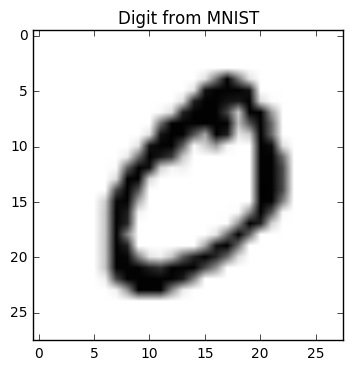

In [3]:

# Images
features = np.array(mnist.data, 'int16')

single_digit = features[0]
plt.title('Digit from MNIST')
plt.imshow(single_digit.reshape(28, 28), cmap='Greys')

# Corresponding digit
labels = np.array(mnist.target, 'int')

# Calculate HOG features for every image in the dataset
hog_features = []


for feature in features:
    fd = hog(feature.reshape(28, 28), orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualise=False)
    hog_features.append(fd)
hog_features = np.array(hog_features, 'float64')

In [4]:
clf = LinearSVC()
clf.fit(hog_features, labels)

# We save classifier to later avoid the need for re-computation
joblib.dump(clf, "digits_classificated.pkl", compress=True)

['digits_classificated.pkl']

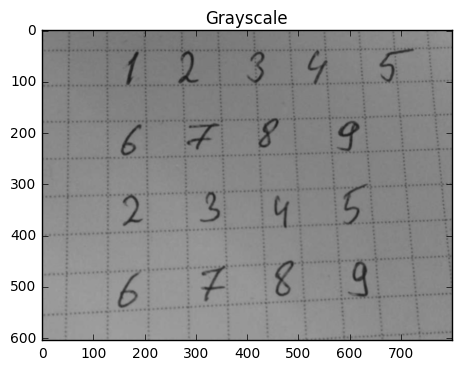

In [5]:
def show_image(img, title="", gray=False):
    # We need to change default BGR to RGB
    if gray:
        new_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        new_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.title(title)
    plt.imshow(new_img)
    plt.show()

digit_image = 'digits.jpg'

im = cv2.imread(digit_image)

# Turn to grayscale
im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
# Apply blur to remove noise
im_gray = cv2.GaussianBlur(im_gray, (5, 5), 0)

show_image(im_gray, title='Grayscale', gray=True)


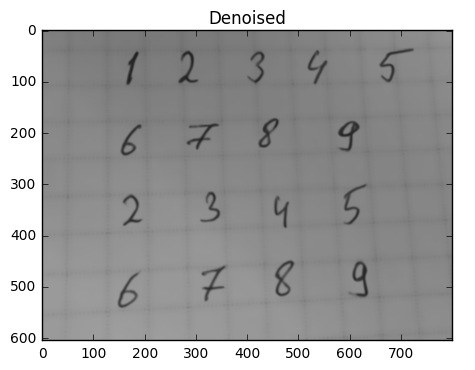

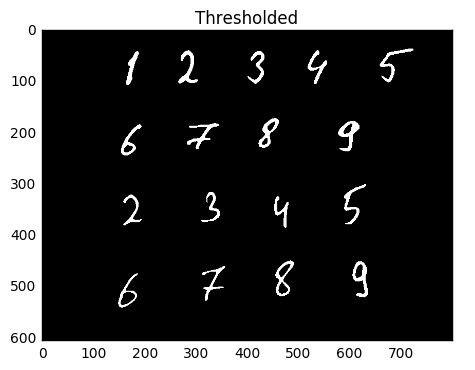

In [6]:
# Remove noise from the image
denoised = cv2.fastNlMeansDenoising(im_gray, h=15)
show_image(denoised, title='Denoised', gray=True)

# Threshold pixels
ret, im_th = cv2.threshold(denoised, 100, 255, cv2.THRESH_BINARY_INV)

show_image(im_th, title='Thresholded', gray=True)

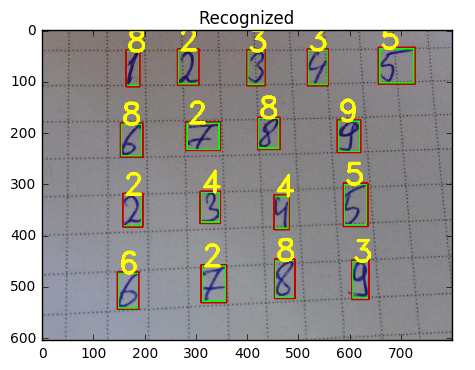

Actual digits: [6, 7, 9, 8, 4, 2, 3, 5, 6, 7, 9, 8, 3, 1, 4, 2, 5]
Predicted digits: [6, 2, 3, 8, 4, 2, 4, 5, 8, 2, 9, 8, 3, 8, 3, 2, 5]
Prediction quotient: 0.5882352941176471


In [7]:
import itertools

CONTOUR_COLOR = (0, 255, 0)
CONTOUR_THICK = 2
CONTOUR_SCALE_FACTOR = 1.1

_, contours, hier = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Find bounding rectangles for each contour

rects = [cv2.boundingRect(ctr) for ctr in contours]

image_copy = im.copy()

predicted_digits = []
for i, rect in enumerate(rects):
    # Draw each rectangle
    x1, y1 = rect[0], rect[1]
    x2, y2 = rect[0] + rect[2], rect[1] + rect[3]
    cv2.rectangle(image_copy, (x1, y1), (x2, y2), CONTOUR_COLOR, CONTOUR_THICK)
    
    # We need to create rectangle region around the digit
    # with some space in order for recognition algorithm to work correctly
    new_width = int(CONTOUR_SCALE_FACTOR * rect[2])
    new_height = int(CONTOUR_SCALE_FACTOR * rect[3])
    new_x = x1 + rect[2] // 2 - new_width // 2
    new_y = y1 + rect[3] // 2 - new_height // 2
    digit = im_th[new_y:new_y + new_height, new_x:new_x + new_width]

    cv2.rectangle(image_copy, (new_x, new_y), (new_x + new_width, new_y + new_height), (0, 0, 200), CONTOUR_THICK)

    resized = cv2.resize(digit, (28, 28), interpolation=cv2.INTER_AREA)
    dilated = cv2.dilate(resized, (4, 4))
    # Calculate HOG features for the new image
    calculated_hog = hog(dilated, orientations=9,
                         pixels_per_cell=(14, 14),
                         cells_per_block=(1, 1),
                         visualise=False)
    predicted_number = int(clf.predict(np.array([calculated_hog], 'float64'))[0])
    
    predicted_digits.append(predicted_number)
    cv2.putText(image_copy, str(predicted_number),
                (rect[0], rect[1]), cv2.FONT_HERSHEY_DUPLEX, 2, (0, 255, 255), 3)
#     break

show_image(image_copy, title='Recognized')

ACTUAL_DIGITS = [6, 7, 9, 8, 
                 4, 2, 3, 5, 
                 6, 7, 9, 8,
                 3, 1, 4, 2,
                 5]
print("Actual digits: {}".format(ACTUAL_DIGITS))
print("Predicted digits: {}".format(predicted_digits))

correct = [(a, p) for (a,p) in zip(ACTUAL_DIGITS, predicted_digits) if a == p]
print("Prediction quotient: {}".format(len(correct) / len(ACTUAL_DIGITS)))